# A2Perf System and Reliability Metrics


In [5]:
!pip install tensorboard sns tbparse matplotlib pandas scipy seaborn tensorflow

In [6]:
import collections
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import tensorboard as tb
import tensorflow as tf
from packaging import version
from scipy import stats
import concurrent.futures

# Set some random seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Set some defaults for seabron and matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.bbox'] = 'tight'


2023-12-10 20:50:44.636680: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 20:50:44.636731: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 20:50:44.636781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 20:50:44.649296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
major_ver, minor_ver, _ = version.parse(tb.__version__).release
assert major_ver >= 2 and minor_ver >= 3, \
  "This notebook requires TensorBoard 2.3 or later."
print("TensorBoard version: ", tb.__version__)

TensorBoard version:  2.14.1


In [8]:
base_dir = '/home/ikechukwuu/workspace/gcs/a2perf/'
debug = False
all_experiments = dict()
locomotion_experiments = {
    "PPO": {
        2223: {  # Experiment ID
            "dog_pace": [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            "dog_trot": [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            "dog_spin": [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
        }
    },
    "DDPG": {
        2223: {  # Experiment ID
            "dog_pace": [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            "dog_trot": [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            "dog_spin": [303, 215, 336, 65, 293, 182, 318, 491,
                         345, 98
                         ],
        }
    }
}

web_navigation_experiments = {
    'DQN_LSTM': {
        'x/...':
          {
              'difficulty_1': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
              'difficulty_2': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
              'difficulty_3': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
          },

    },
    'PPO_LSTM': {
        'x/...':
          {
              'difficulty_1': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
              'difficulty_2': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
              'difficulty_3': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
          },

    }
}

circuit_training_experiments = {
    'PPO': {
        'x/...': {
            'ariane133': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            'ariane134': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            'memloop': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
        }
    },
    'DQN': {
        'x/...': {
            'ariane133': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            'ariane134': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
            'memloop': [303, 215, 336, 65, 293, 182, 318, 491, 345, 98],
        }
    }
}
all_experiments['quadruped_locomotion'] = locomotion_experiments

# Training Metrics

## Reliability Metrics

In [9]:
log_dirs = []
for domain, experiments in all_experiments.items():
  for algo, exp_dict in experiments.items():
    for exp_id, task_dict in exp_dict.items():
      for task, seeds in task_dict.items():
        for seed in seeds:
          experiment_path = os.path.join(base_dir, domain,
                                         task, algo.lower(), str(exp_id),
                                         f'**/tensorboard/{algo}_0_1/*events*')
          log_dirs.extend(glob.glob(experiment_path, recursive=True))
log_dirs = set(log_dirs)
len(log_dirs), log_dirs

(60,
 {'/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_182_total_env_steps_200000000/tensorboard/DDPG_0_1/events.out.tfevents.1700404642.locomotion-4',
  '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_215_total_env_steps_200000000/tensorboard/DDPG_0_1/events.out.tfevents.1700406337.locomotion-3',
  '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_293_total_env_steps_200000000/tensorboard/DDPG_0_1/events.out.tfevents.1700345090.locomotion-4',
  '/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cor

### Pack Data into DataFrame

In [10]:
def load_tb_data(event_file):
  iterations_data = dict()
  ep_rew_data = dict()
  timestamp_data = dict()

  for event in tf.compat.v1.train.summary_iterator(event_file):
    # get the timestamp of the evnet
    timestamp = event.wall_time

    # Convert the timestamp to a datetime object
    timestamp = pd.to_datetime(timestamp, unit='s')
    timestamp_data[event.step] = timestamp

    for value in event.summary.value:
      # Check for episode_reward in the event
      if value.tag == 'episode_reward':
        if event.step in ep_rew_data:
          raise ValueError(
              f'Found duplicate episode_reward data for step: {event.step}')
        ep_rew_data[event.step] = value.simple_value

      # Check for iterations in the event
      if value.tag == 'iterations':
        if event.step in iterations_data:
          raise ValueError(
              f'Found duplicate iterations data for step: {event.step}')
        iterations_data[event.step] = value.simple_value

  df = pd.DataFrame.from_dict(iterations_data, orient='index',
                              columns=['iterations'])
  df['episode_reward'] = df['iterations'].map(ep_rew_data)
  df['timestamp'] = df['iterations'].map(timestamp_data)
  df = df.reset_index()
  df = df.rename(columns={'index': 'step'})
  df = df.drop(columns=['iterations'])
  df['step'] = df['step'].astype(np.int32)
  return df


In [11]:
def process_log_dir(log_dir):
  log_base_dir = os.path.dirname(log_dir)
  exp_split = log_dir.split('/')

  exp_name = exp_split[-4]
  exp_name_split = exp_name.split('_')

  seed = int(exp_name_split[-5])
  experiment = exp_split[-5]
  algo = exp_split[-6]
  task = exp_split[-7]
  domain = exp_split[-8]

  if algo.upper() not in all_experiments['quadruped_locomotion'].keys():
    return None  # Skipping the directory

  if os.path.exists(os.path.join(log_base_dir, 'data.csv')):
    data = pd.read_csv(os.path.join(log_base_dir, 'data.csv'))
    print(f'Loaded data from {log_base_dir}')
  else:
    data = load_tb_data(
        log_dir)  # Assuming load_tb_data is a function you have defined
    if 'timestamp' in data.columns:
      data['timestamp'] = pd.to_datetime(data['timestamp']).apply(
          lambda x: x.replace(tzinfo=None) if x.tzinfo else x)

    data['seed'] = seed
    data['experiment'] = int(experiment)
    data['algo'] = algo.upper()
    data['domain'] = domain
    data['task'] = task
    data.to_csv(os.path.join(log_base_dir, 'data.csv'))

  return data

In [12]:
# Parallel processing
all_dfs = []
with concurrent.futures.ProcessPoolExecutor() as executor:
  for data in executor.map(process_log_dir, log_dirs):
    if data is not None:
      # print logging message based on the log dir
      print(
          f'Processing log dir: {data.iloc[0]["domain"]}/{data.iloc[0]["task"]}/{data.iloc[0]["algo"]}/{data.iloc[0]["experiment"]}/{data.iloc[0]["seed"]}')
      # do the timestamp conversion here to save time
      data['timestamp'] = pd.to_datetime(data['timestamp']).apply(
          lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
      all_dfs.append(data)

all_df = pd.concat(all_dfs)

Loaded data from /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_trot/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_215_total_env_steps_200000000/tensorboard/DDPG_0_1Loaded data from /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_trot/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_182_total_env_steps_200000000/tensorboard/DDPG_0_1Loaded data from /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_trot/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_98_total_env_steps_200000000/tensorboard/PPO_0_1Loaded data from /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_spin/ppo/2223/quadruped_locomotion_algo_ppo_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_293_total_env_steps_200000000/tensorboard/PPO_0_1Loaded data from /home/ikechukwuu/w

In [13]:
# Make sure all_df is sorted by step for our analysis below
all_df = all_df.sort_values(
    by=['domain', 'task', 'algo', 'seed',
        'step'])  # or 'time' instead of 'step'

In [14]:
# for each algo, domain and task, get the number of seeds, but use pandas
# groupby
seed_counts = all_df.groupby(['algo', 'domain', 'task'])['seed'].nunique()
print(seed_counts)

row_counts = all_df.groupby(['algo', 'domain', 'task'])['seed'].count()
print(row_counts)

algo  domain                task    
DDPG  quadruped_locomotion  dog_pace    10
                            dog_spin    10
                            dog_trot    10
PPO   quadruped_locomotion  dog_pace    10
                            dog_spin    10
                            dog_trot    10
Name: seed, dtype: int64
algo  domain                task    
DDPG  quadruped_locomotion  dog_pace    467840
                            dog_spin    467840
                            dog_trot    467840
PPO   quadruped_locomotion  dog_pace    470590
                            dog_spin    470590
                            dog_trot    470590
Name: seed, dtype: int64


### Variations in Plotting

In [15]:
def prepare_data_for_task(task):
  """
  Prepare data for a specific task.
  """
  # Create a copy of the dataframe slice to avoid SettingWithCopyWarning
  task_df = all_df[all_df['task'] == task].copy()
  task_df['step_to_plot'] = task_df['step'] * 4096
  return task_df

In [16]:
def plot_data_steps(task_df, x_column, y_column, hue_column, task,
    save_prefix=''):
  """
  Plot data for a specific task.
  """
  plt.figure()

  algo_list = task_df[hue_column].unique()  # Get the unique algorithms
  algo_list = np.sort(algo_list)  # Sort the algorithms
  hue_order = algo_list.tolist()  # Convert to a list

  axes = sns.lineplot(x=x_column, y=y_column, hue=hue_column, data=task_df,
                      errorbar='sd', palette='colorblind', hue_order=hue_order)

  for line in axes.lines:
    line.set_alpha(0.75)

  axes.set_xlabel('Training Step', fontsize=14)
  axes.set_ylabel('Episode Reward', fontsize=14)

  task_title = task.replace('_', ' ').title()
  axes.set_title(f'Algorithm Comparison for Task: {task_title}', fontsize=16)
  axes.legend(title='Algorithm', loc='upper left', fontsize='medium')
  sns.despine()
  plt.show()

  # Save the plot based on the task and any other identifiable information
  plt.savefig(f'{save_prefix}_{task}.png', dpi=300)

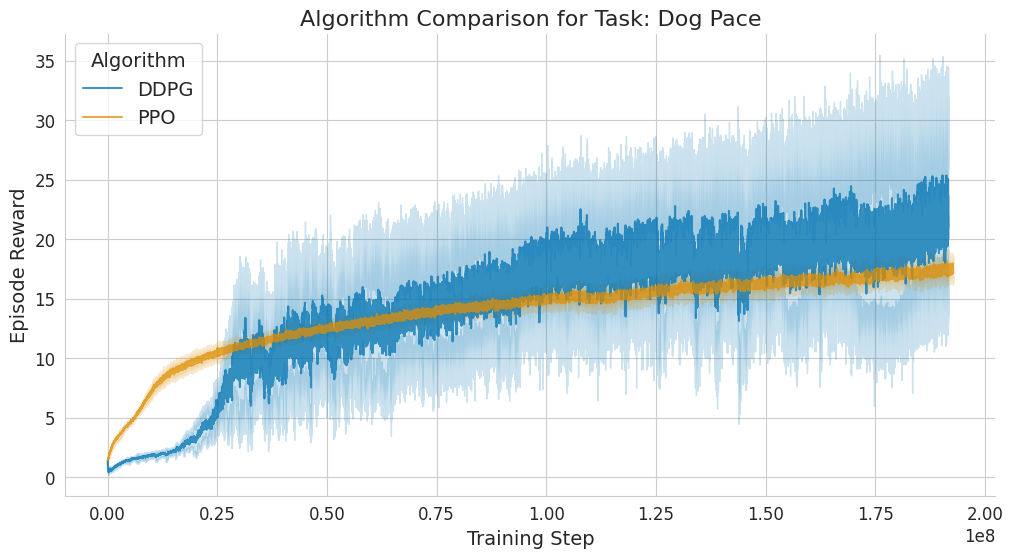

<Figure size 1200x600 with 0 Axes>

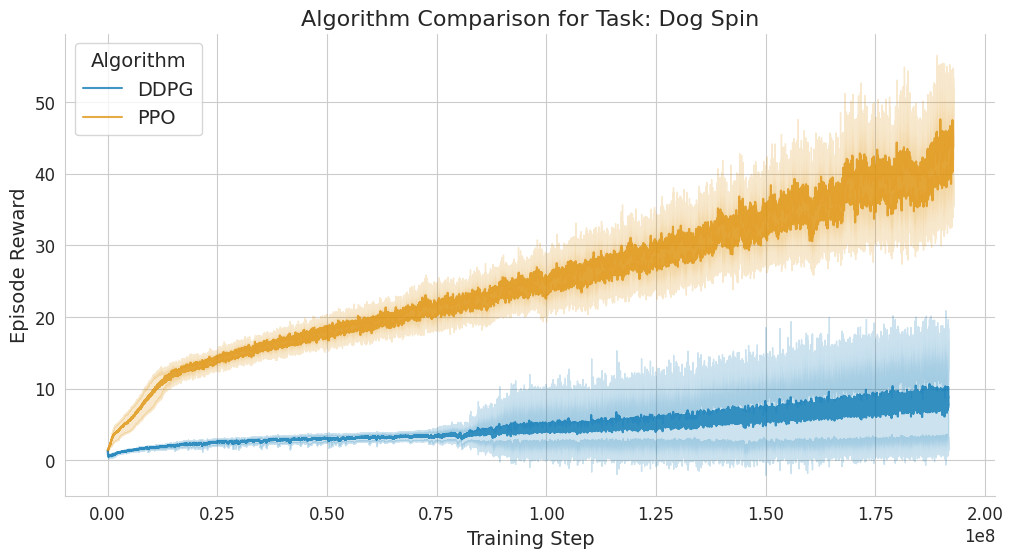

<Figure size 1200x600 with 0 Axes>

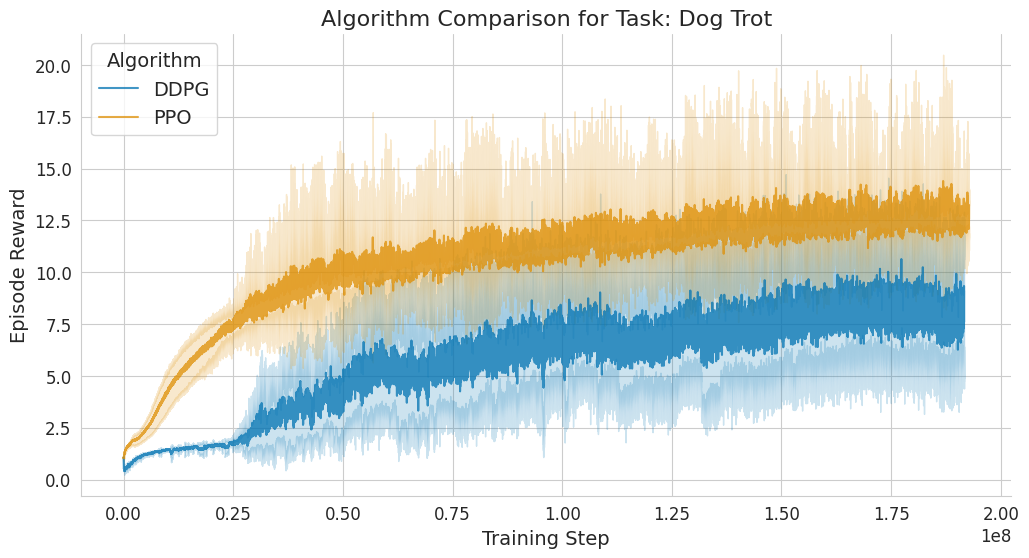

<Figure size 1200x600 with 0 Axes>

In [17]:
# Parallel data preparation
tasks = all_df['task'].unique()
prepared_data = []

with concurrent.futures.ProcessPoolExecutor() as executor:
  for task_df in executor.map(prepare_data_for_task, tasks):
    prepared_data.append((task_df, task_df['task'].iloc[0]))

# Sequential plotting
for task_df, task in prepared_data:
  plot_data_steps(task_df, 'step_to_plot', 'episode_reward', 'algo', task,
                  save_prefix='steps')


In [18]:
#  Subtract minimum timestamp for each group
all_df['timestamp_adjusted'] = all_df.groupby(
    ['domain', 'experiment', 'algo', 'task', 'seed'])['timestamp'].transform(
    lambda x: x - x.min())


In [19]:
# Convert to seconds and round to nearest second
all_df['timestamp_adjusted'] = all_df[
  'timestamp_adjusted'].dt.total_seconds().round().astype(np.int64)

In [20]:
# Let's examine a single group to make sure the timestamps make sense. Choose the group with seed=303, task=dog_pace, algo=PPO, experiment=2223
seed_df = all_df[
  (all_df['seed'] == 303) & (all_df['task'] == 'dog_pace') & (
      all_df['algo'] == 'PPO') & (all_df['experiment'] == 2223)]

In [21]:
# sort seed_df by timestamp_adjusted. if  we sort timestamp_adjusted, then step should be sorted as well
seed_df = seed_df.sort_values(by='timestamp_adjusted')
seed_df

,Unnamed: 0,step,episode_reward,timestamp,seed,experiment,algo,domain,task,timestamp_adjusted
1,1,1,1.451540,2023-11-18 22:03:05.271953408,303,2223,PPO,quadruped_locomotion,dog_pace,0
2,2,2,1.395885,2023-11-18 22:03:05.972748800,303,2223,PPO,quadruped_locomotion,dog_pace,1
3,3,3,1.464409,2023-11-18 22:03:06.655704320,303,2223,PPO,quadruped_locomotion,dog_pace,1
4,4,4,1.392638,2023-11-18 22:03:07.275486208,303,2223,PPO,quadruped_locomotion,dog_pace,2
5,5,5,1.420278,2023-11-18 22:03:07.883803648,303,2223,PPO,quadruped_locomotion,dog_pace,3
...,...,...,...,...,...,...,...,...,...,...
47056,47056,47056,17.609381,2023-11-19 06:32:02.473734912,303,2223,PPO,quadruped_locomotion,dog_pace,30537
47055,47055,47055,16.994703,2023-11-19 06:32:01.888301824,303,2223,PPO,quadruped_locomotion,dog_pace,30537
0,0,0,1.424293,2023-11-19 06:32:03.703111168,303,2223,PPO,quadruped_locomotion,dog_pace,30538
47057,47057,47057,17.382463,2023-11-19 06:32:03.085748992,303,2223,PPO,quadruped_locomotion,dog_pace,30538


In [22]:
def prepare_data_for_task(task):
  """
  Prepare data for a specific task.
  """
  # Create a copy of the dataframe slice to avoid SettingWithCopyWarning
  task_df = all_df[all_df['task'] == task]
  return task_df

In [23]:
def plot_data_duration(task_df, x_column, y_column, hue_column, task,
    save_prefix=''):
  """
  Plot data for a specific task.
  """
  plt.figure()
  algo_list = task_df[hue_column].unique()  # Get the unique algorithms
  algo_list = np.sort(algo_list)  # Sort the algorithms
  hue_order = algo_list.tolist()  # Convert to a list

  axes = sns.lineplot(x=x_column, y=y_column, hue=hue_column, data=task_df,
                      errorbar='sd', palette='colorblind', hue_order=hue_order)
  for line in axes.lines:
    line.set_alpha(0.75)

  max_timestamps = task_df.groupby(['algo', 'seed'])[
    'timestamp_adjusted'].max().reset_index()
  min_of_max_timestamps = max_timestamps['timestamp_adjusted'].min()

  axes.set_xlim(0, min_of_max_timestamps)
  axes.set_xlabel('Duration (seconds)', fontsize=14)
  axes.set_ylabel('Episode Reward', fontsize=14)
  task_title = task.replace('_', ' ').title()

  axes.set_title(f'Algorithm Comparison for Task: {task_title}', fontsize=16)
  axes.legend(title='Algorithm', loc='upper left', fontsize='medium')
  sns.despine()
  plt.show()

  plt.savefig(f'{save_prefix}_{task}.png', dpi=300)


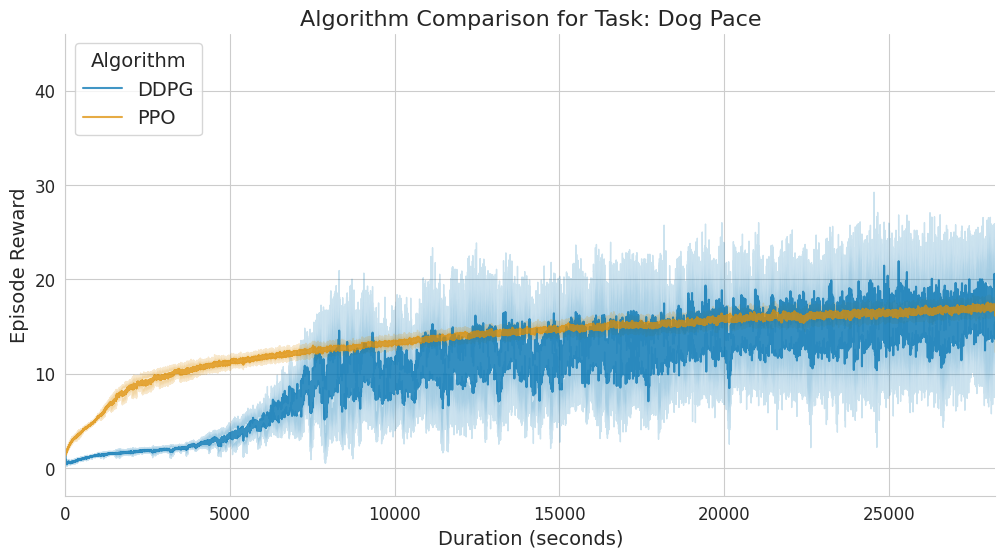

<Figure size 1200x600 with 0 Axes>

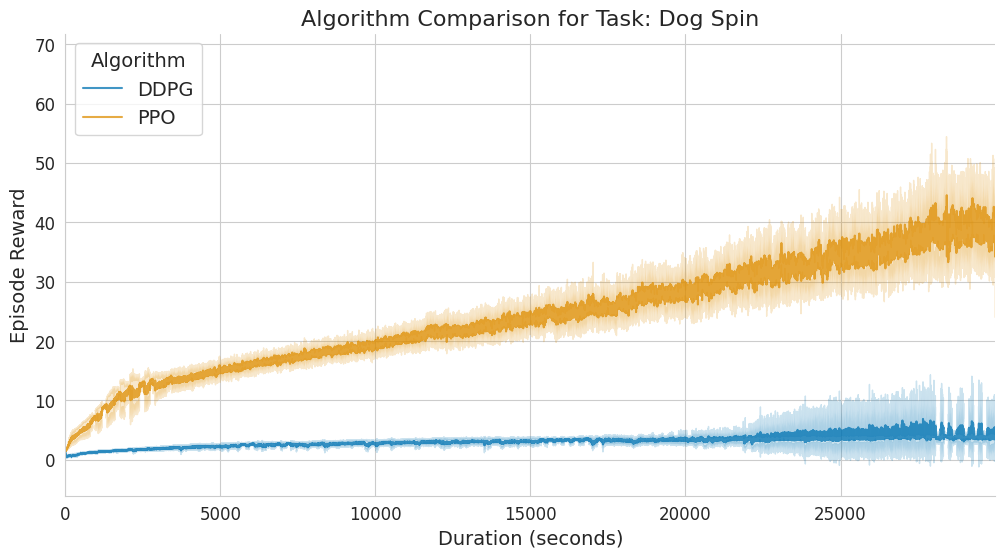

<Figure size 1200x600 with 0 Axes>

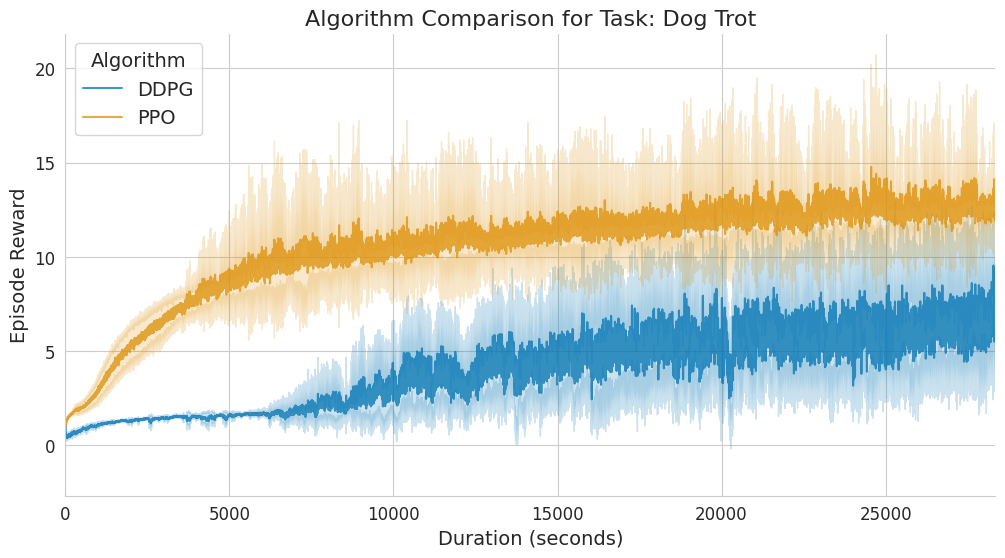

<Figure size 1200x600 with 0 Axes>

In [24]:
# Parallel data preparation
tasks = all_df['task'].unique()
prepared_data = []

with concurrent.futures.ProcessPoolExecutor() as executor:
  for task_df in executor.map(prepare_data_for_task, tasks):
    prepared_data.append((task_df, task_df['task'].iloc[0]))

for task_df, task in prepared_data:
  plot_data_duration(task_df, 'timestamp_adjusted', 'episode_reward', 'algo',
                     task,
                     save_prefix='duration')


### Determining the score thresholds for difficulties

In [25]:
def calculate_score_bounds_per_task(df, group_cols, reward_col):
  bounds_per_task = {}

  for group_keys, group in df.groupby(group_cols):
    mean_reward = group[reward_col].mean()
    std_reward = group[reward_col].std()

    bounds_per_task[group_keys] = {
        'novice': (-np.inf, mean_reward - (2 * std_reward)),
        'intermediate': (mean_reward - std_reward, mean_reward + std_reward),
        'expert': (mean_reward + (2 * std_reward), np.inf)
    }

  return bounds_per_task

In [26]:
group_columns = ['domain', 'task']
score_bounds = calculate_score_bounds_per_task(all_df, group_columns,
                                               'episode_reward')
score_bounds

{('quadruped_locomotion', 'dog_pace'): {'novice': (-inf, 2.431718375770954),
  'intermediate': (8.3368632329224, 20.147152947225297),
  'expert': (26.052297804376742, inf)},
 ('quadruped_locomotion', 'dog_spin'): {'novice': (-inf, -10.537825487110691),
  'intermediate': (2.042392144121978, 27.202827406587318),
  'expert': (39.78304503781999, inf)},
 ('quadruped_locomotion', 'dog_trot'): {'novice': (-inf, 0.03774947198522227),
  'intermediate': (4.074026771879259, 12.146581371667333),
  'expert': (16.18285867156137, inf)}}

In [27]:
def assign_expertise_level(row, bounds):
  """
  Assign expertise level to a row based on episode_reward and predefined bounds.
  """
  task_key = (row['domain'], row['task'])  # Create the key tuple for the task
  reward = row['episode_reward']

  # Check against the bounds and assign the level
  if reward <= bounds[task_key]['novice'][1]:
    return 'novice'
  elif bounds[task_key]['novice'][1] < reward <= \
      bounds[task_key]['intermediate'][1]:
    return 'intermediate'
  elif reward > bounds[task_key]['intermediate'][1]:
    return 'expert'

In [28]:
# Assuming all_df is your DataFrame and score_bounds contains the bounds per task
all_df['expertise_level'] = all_df.apply(assign_expertise_level, axis=1,
                                         bounds=score_bounds)

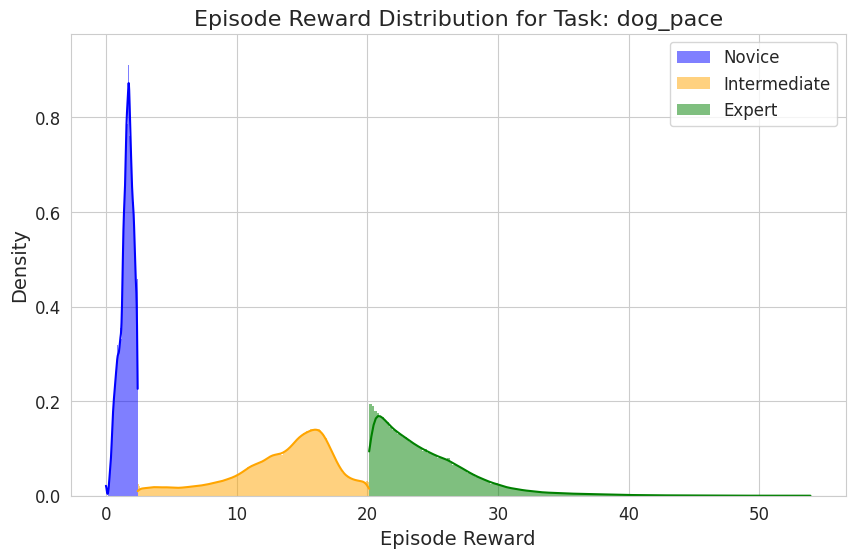

/home/ikechukwuu/workspace/rl-perf/env/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


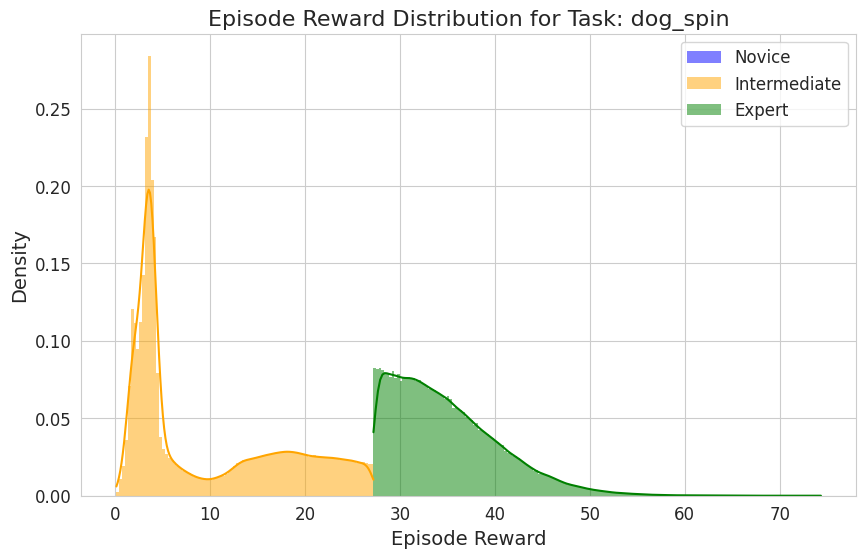

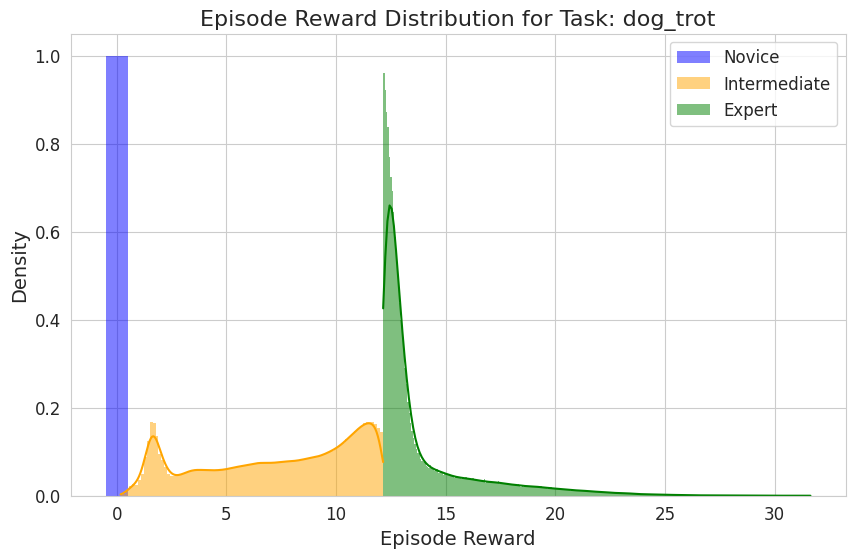

In [29]:

# Now plot histograms of the episode_rewards for each TASK, but change the color based on the expertise level
for task, group in all_df.groupby('task'):
  plt.figure(figsize=(10, 6))  # Set the figure size for better visibility

  # Plot histograms for each expertise level on the same axes
  sns.histplot(data=group[group['expertise_level'] == 'novice'],
               x='episode_reward', color='blue', label='Novice', kde=True,
               stat="density", linewidth=0)
  sns.histplot(data=group[group['expertise_level'] == 'intermediate'],
               x='episode_reward', color='orange', label='Intermediate',
               kde=True, stat="density", linewidth=0)
  sns.histplot(data=group[group['expertise_level'] == 'expert'],
               x='episode_reward', color='green', label='Expert', kde=True,
               stat="density", linewidth=0)

  plt.title(f'Episode Reward Distribution for Task: {task}')
  plt.xlabel('Episode Reward')  # Label for the x-axis
  plt.ylabel('Density')  # Label for the y-axis
  plt.legend()  # Show the legend
  plt.show()  # Display the plot

### Use the saved checkpoints to select policies for data generation

In [30]:
all_policy_paths = []
for domain, experiments in all_experiments.items():
  for algo, exp_dict in experiments.items():
    for exp_id, task_dict in exp_dict.items():
      for task, seeds in task_dict.items():
        for seed in seeds:
          experiment_path = os.path.join(base_dir, domain,
                                         'debug' if debug else '',
                                         task, algo.lower(), str(exp_id),
                                         f'**/policies/*_steps.zip')
          policies_paths = glob.glob(experiment_path, recursive=True)
          print(f'Experiment Path: {experiment_path}')
          print(f'Number of policies: {len(policies_paths)}')

          all_policy_paths.extend(policies_paths)
len(all_policy_paths)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ppo/2223/**/policies/*_steps.zip
Number of policies: 2010

120000

In [31]:
all_policy_paths = set(all_policy_paths)

In [32]:
policy_path_df = pd.DataFrame(all_policy_paths, columns=['path'])
policy_path_df.head()

,path
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...


In [33]:
policy_path_df['step'] = policy_path_df['path'].str.extract(
    r'(\d+)_steps.zip', expand=False).astype(np.int64)
policy_path_df['step'] = policy_path_df['step'] // 4096
policy_path_df['step'] = policy_path_df['step'].astype(np.int64)
policy_path_df['seed'] = policy_path_df['path'].str.extract(r'seed_(\d+)',
                                                            expand=False).astype(
    np.int64)

policy_path_df['domain'] = 'quadruped_locomotion'
policy_path_df['task'] = policy_path_df['path'].str.extract(
    r'quadruped_locomotion/(\w+)/', expand=False)
policy_path_df['algo'] = policy_path_df['path'].str.extract(
    r'quadruped_locomotion/\w+/(\w+)/', expand=False)
# capitalise the algo
policy_path_df['algo'] = policy_path_df['algo'].str.upper()
policy_path_df.head()

,path,step,seed,domain,task,algo
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,4169,303,quadruped_locomotion,dog_trot,DDPG
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,43647,215,quadruped_locomotion,dog_spin,PPO
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,21946,215,quadruped_locomotion,dog_pace,PPO
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,24628,318,quadruped_locomotion,dog_spin,PPO
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,40714,65,quadruped_locomotion,dog_spin,DDPG


In [34]:
policy_path_df_sorted = policy_path_df.sort_values('step')
all_df_sorted = all_df[['domain', 'task', 'algo', 'seed', 'step',
                        'episode_reward', 'expertise_level']].sort_values(
    'step')

In [35]:
# Merge with a tolerance of 4000 steps
dataset_df = pd.merge_asof(policy_path_df_sorted,
                           all_df_sorted,
                           on='step',
                           by=['domain', 'task', 'algo', 'seed'],
                           direction='nearest',
                           tolerance=4000)
dataset_df.head()

,path,step,seed,domain,task,algo,episode_reward,expertise_level
0,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,1,303,quadruped_locomotion,dog_pace,PPO,1.451540,novice
1,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,1,293,quadruped_locomotion,dog_spin,PPO,1.494671,intermediate
2,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,1,491,quadruped_locomotion,dog_spin,PPO,1.374325,intermediate
3,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,1,318,quadruped_locomotion,dog_spin,PPO,1.304278,intermediate
4,/home/ikechukwuu/workspace/gcs/a2perf/quadrupe...,1,182,quadruped_locomotion,dog_pace,PPO,1.928185,novice


In [36]:
len(dataset_df)

12000

In [37]:
NUM_POLICIES_PER_EXPERTISE_LEVEL = 25

expertise_level_to_policy_paths = collections.defaultdict(dict)
for expertise_level, group in dataset_df.groupby('expertise_level'):
  for domain_task, domain_task_group in group.groupby(['domain', 'task']):
    expertise_level_to_policy_paths[expertise_level][domain_task] = \
      domain_task_group['path'].values

    # Choose random policies
    expertise_level_to_policy_paths[expertise_level][domain_task] = \
      np.random.choice(domain_task_group['path'].values,
                       NUM_POLICIES_PER_EXPERTISE_LEVEL, replace=False)

In [38]:
expertise_level_to_policy_paths.keys()

dict_keys(['expert', 'intermediate', 'novice'])

In [39]:
# print out the policies in such a way that i can copy it into a python variable.
# we should use dictionaries like domain -> task -> expertise_level -> policy_paths
for expertise_level, domain_task_dict in expertise_level_to_policy_paths.items():
  print(f'expertise_level_to_policy_paths["{expertise_level}"] = dict()')
  for domain_task, policy_paths in domain_task_dict.items():
    print(
        f'\texpertise_level_to_policy_paths["{expertise_level}"]["{domain_task}"] = [')
    for policy_path in policy_paths:
      print(f'\t\t"{policy_path}",')
    print('\t]')
  print()

expertise_level_to_policy_paths["expert"] = dict()
	expertise_level_to_policy_paths["expert"]["('quadruped_locomotion', 'dog_pace')"] = [
		"/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_345_total_env_steps_200000000/policies/rl_policy_98453250_steps.zip",
		"/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_215_total_env_steps_200000000/policies/rl_policy_175809375_steps.zip",
		"/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_int_eval_freq_100000_int_save_freq_1000000_parallel_cores_170_seed_65_total_env_steps_200000000/policies/rl_policy_172795500_steps.zip",
		"/home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/quadruped_locomotion_algo_ddpg_in

## Training Metrics

In [40]:
EVAL_POINTS_PER_WINDOW = 5

all_training_metrics = collections.defaultdict(dict)

In [41]:
for domain, domain_group in all_df.groupby('domain'):
  print(f'Processing domain: {domain}')
  for task, task_group in domain_group.groupby('task'):
    print(f'\tProcessing task: {task}')
    for algo, algo_group in task_group.groupby('algo'):
      print(f'\t\tProcessing algo: {algo}')
      for exp_id, exp_group in algo_group.groupby('experiment'):
        for seed, seed_group in exp_group.groupby('seed'):
          seed_df = seed_group.sort_values(by='step').copy()
          median_step_diff = seed_df['step'].diff().median()
          window_size = int(EVAL_POINTS_PER_WINDOW * median_step_diff)
          eval_points = list(
              range(np.ceil(window_size / 2).astype(int),
                    max(all_df['step']), int(median_step_diff)))
          print(
              f'Domain: {domain}, Algo: {algo}, Experiment: {exp_id}, Task: {task}, Seed: {seed}')
          print(f'\tMedian step difference: {median_step_diff}')
          print(f'\tWindow size: {window_size}')
          print()
          all_training_metrics[(domain, algo, exp_id, task, seed)][
            'eval_points'] = eval_points
          all_training_metrics[(domain, algo, exp_id, task, seed)][
            'window_size'] = window_size
          all_training_metrics[(domain, algo, exp_id, task, seed)][
            'median_step_diff'] = median_step_diff

Processing domain: quadruped_locomotion
	Processing task: dog_pace
		Processing algo: DDPG
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 65
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 98
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 182
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 215
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 293
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 303
	Median step difference: 1.0
	Window size: 5
Domain: quadruped_locomotion, Algo: DDPG, Experiment: 2223, Task: dog_pace, Seed: 318
	Median step difference: 1.0
	Window si

### Computing Reliability Metrics

In [42]:
window_fn = scipy.stats.iqr

In [43]:
for domain, domain_group in all_df.groupby('domain'):
  print(f'Processing domain: {domain}')
  for task, task_group in domain_group.groupby('task'):
    print(f'\tProcessing task: {task}')
    for algo, algo_group in task_group.groupby('algo'):
      print(f'\t\tProcessing algo: {algo}')
      all_iqr_values = []
      for exp_id, exp_group in algo_group.groupby('experiment'):
        for seed, seed_group in exp_group.groupby('seed'):
          seed_group['episode_reward_diff'] = seed_group[
            'episode_reward'].diff()
          seed_group = seed_group[['step', 'episode_reward_diff']].copy()
          seed_group = seed_group.dropna()
          steps, episode_reward_diff = seed_group.to_numpy().T

          window_size = \
            all_training_metrics[(domain, algo, exp_id, task, seed)][
              'window_size']
          for eval_point in \
              all_training_metrics[(domain, algo, exp_id, task, seed)][
                'eval_points']:
            low_end = np.ceil(eval_point - (window_size / 2))
            high_end = np.floor(eval_point + (window_size / 2))

            eval_points_above = steps >= low_end
            eval_points_below = steps <= high_end
            eval_points_in_window = np.logical_and(eval_points_above,
                                                   eval_points_below)
            valid_eval_points = np.nonzero(eval_points_in_window)[0]

            if len(valid_eval_points) == 0:
              break

            # Apply window_fn to get the IQR for the current window
            window_iqr = window_fn(episode_reward_diff[valid_eval_points])
            all_iqr_values.append(window_iqr)
      mean_iqr = np.mean(all_iqr_values)
      std_iqr = np.std(all_iqr_values)
      all_training_metrics[(domain, algo, task,)][
        'dispersion_within_runs'] = dict(
          mean=mean_iqr, std=std_iqr)
      print(
          f'Domain: {domain}, Task: {task}, Algo: {algo}, Mean IQR: {mean_iqr}, Std IQR: {std_iqr}')

Processing domain: quadruped_locomotion
	Processing task: dog_pace
		Processing algo: DDPG
Domain: quadruped_locomotion, Task: dog_pace, Algo: DDPG, Mean IQR: 3.735917627702818, Std IQR: 3.392193220039115
		Processing algo: PPO
Domain: quadruped_locomotion, Task: dog_pace, Algo: PPO, Mean IQR: 0.6406753871007929, Std IQR: 0.4358594855444334
	Processing task: dog_spin
		Processing algo: DDPG
Domain: quadruped_locomotion, Task: dog_spin, Algo: DDPG, Mean IQR: 0.7607203149314318, Std IQR: 1.8121423613495913
		Processing algo: PPO
Domain: quadruped_locomotion, Task: dog_spin, Algo: PPO, Mean IQR: 3.1423407868692466, Std IQR: 3.038005429257711
	Processing task: dog_trot
		Processing algo: DDPG
Domain: quadruped_locomotion, Task: dog_trot, Algo: DDPG, Mean IQR: 1.600818316397926, Std IQR: 1.579099022450178
		Processing algo: PPO
Domain: quadruped_locomotion, Task: dog_trot, Algo: PPO, Mean IQR: 0.8483868983721407, Std IQR: 1.5155623387902697



##### Long-term risk across time
Long - term risk across time represents the propensity of the agent to crash after achieving a higher performance measure

In [44]:
def compute_drawdown(sequence):
  """Computes the drawdown for a sequence of numbers.

    The drawdown at time T is the decline from the highest peak occurring at or
    before time T. https://en.wikipedia.org/wiki/Drawdown_(economics).

    The drawdown is always non-negative. A larger (more positive) drawdown
    indicates a larger drop.

  Args:
    sequence: A numpy array.

  Returns:
    A numpy array of same length as the original sequence, containing the
      drawdown at each timestep.
  """
  peak_so_far = np.maximum.accumulate(sequence)
  return peak_so_far - sequence

In [45]:

alpha = 0.95

for domain, domain_group in all_df.groupby('domain'):
  print(f'Processing domain: {domain}')
  for task, task_group in domain_group.groupby('task'):
    print(f'\tProcessing task: {task}')
    for algo, algo_group in task_group.groupby('algo'):
      print(f'\t\tProcessing algo: {algo}')
      all_drawdowns = []
      for exp_id, exp_group in algo_group.groupby('experiment'):
        for seed, seed_group in exp_group.groupby('seed'):
          # Compute the drawdowns
          episode_rewards = seed_group['episode_reward'].values
          drawdowns = compute_drawdown(episode_rewards)
          all_drawdowns.extend(drawdowns)

      # Get the bottom "alpha" percent of drawdowns (we use the 95th percentile to get the bottom 5% of drawdowns)
      top_alpha_percent = np.percentile(all_drawdowns, alpha * 100)
      all_drawdowns = np.array(all_drawdowns)

      # CVaR is the average of the bottom "alpha" percent of drawdowns
      cvar = np.mean(all_drawdowns[all_drawdowns >= top_alpha_percent])

      print(f'\t\t\tCVaR: {cvar}')

      # Add the cvar to the dictionary
      all_training_metrics[(domain, algo, task,)]['long_term_risk'] = cvar


Processing domain: quadruped_locomotion
	Processing task: dog_pace
		Processing algo: DDPG
			CVaR: 22.81156653116512
		Processing algo: PPO
			CVaR: 3.1834130707468016
	Processing task: dog_spin
		Processing algo: DDPG
			CVaR: 18.0184382771826
		Processing algo: PPO
			CVaR: 28.024510646403417
	Processing task: dog_trot
		Processing algo: DDPG
			CVaR: 11.344452943479599
		Processing algo: PPO
			CVaR: 16.023946737584488


##### Short-term risk across time
Short - term risk across time represents how volatile the agent is from eval point to eval point

In [46]:
alpha = 0.05

for domain, domain_group in all_df.groupby('domain'):
  print(f'Processing domain: {domain}')
  for task, task_group in domain_group.groupby('task'):
    print(f'\tProcessing task: {task}')
    for algo, algo_group in task_group.groupby('algo'):
      print(f'\t\tProcessing algo: {algo}')
      all_diffs = []
      for exp_id, exp_group in algo_group.groupby('experiment'):
        for seed, seed_group in exp_group.groupby('seed'):
          seed_df = seed_group.sort_values(by='step').copy()
          seed_df['episode_reward_diff'] = seed_df['episode_reward'].diff()
          seed_df = seed_df.dropna()

          episode_reward_diffs = seed_df['episode_reward_diff'].values
          all_diffs.extend(episode_reward_diffs)

      bottom_alpha_percent = np.percentile(all_diffs, alpha * 100,
                                           method='linear')

      # CVaR is the average of the bottom "alpha" percent of diffs
      all_diffs = np.array(all_diffs)
      cvar = np.mean(
          all_diffs[all_diffs <= bottom_alpha_percent])
      cvar = -cvar  # make it positive for easier interpretation
      print(f'\t\t\tCVaR: {cvar}')
      all_training_metrics[(domain, algo, task,)][
        'short_term_risk'] = cvar


Processing domain: quadruped_locomotion
	Processing task: dog_pace
		Processing algo: DDPG
			CVaR: 9.242292702269374
		Processing algo: PPO
			CVaR: 1.2769236091629335
	Processing task: dog_spin
		Processing algo: DDPG
			CVaR: 3.8800913552701393
		Processing algo: PPO
			CVaR: 8.165244337887115
	Processing task: dog_trot
		Processing algo: DDPG
			CVaR: 4.110348950956837
		Processing algo: PPO
			CVaR: 3.219938255642258



##### Risk across runs
Risk across runs tells use how poor the final performance of the worst runs are

In [47]:
# Get the final episode reward for each seed
final_episode_rewards = all_df.groupby(['domain', 'task', 'algo', 'seed'])[
  'episode_reward'].last().reset_index()
final_episode_rewards

,domain,task,algo,seed,episode_reward
0,quadruped_locomotion,dog_pace,DDPG,65,28.517708
1,quadruped_locomotion,dog_pace,DDPG,98,20.178585
2,quadruped_locomotion,dog_pace,DDPG,182,15.044183
3,quadruped_locomotion,dog_pace,DDPG,215,23.308825
4,quadruped_locomotion,dog_pace,DDPG,293,23.822138
5,quadruped_locomotion,dog_pace,DDPG,303,13.111123
6,quadruped_locomotion,dog_pace,DDPG,318,22.191414
7,quadruped_locomotion,dog_pace,DDPG,336,19.328659
8,quadruped_locomotion,dog_pace,DDPG,345,26.464947
9,quadruped_locomotion,dog_pace,DDPG,491,27.958492


In [48]:
# Now we just need to compute the CVaR of the final episode rewards
alpha = 0.05

# all experiments and seeds within a specific domain/task/algo should be grouped together
for domain, domain_group in final_episode_rewards.groupby('domain'):
  for task, task_group in domain_group.groupby('task'):
    for algo, algo_group in task_group.groupby('algo'):
      # print(algo_group)  # this is the group we want to compute the CVaR for

      # Get the bottom "alpha" percent of final episode rewards
      rewards = algo_group['episode_reward'].values
      bottom_alpha_percent = np.percentile(rewards, alpha * 100,
                                           method='linear')
      cvar = np.mean(rewards[rewards <= bottom_alpha_percent])

      print(f'Processing domain: {domain}, task: {task}, algo: {algo}')
      print(f'\tCVaR: {cvar}')
      all_training_metrics[(domain, algo, task,)][
        'risk_across_runs'] = cvar

Processing domain: quadruped_locomotion, task: dog_pace, algo: DDPG
	CVaR: 13.111123085021973
Processing domain: quadruped_locomotion, task: dog_pace, algo: PPO
	CVaR: 16.022621154785156
Processing domain: quadruped_locomotion, task: dog_spin, algo: DDPG
	CVaR: 2.372466325759888
Processing domain: quadruped_locomotion, task: dog_spin, algo: PPO
	CVaR: 35.01372528076172
Processing domain: quadruped_locomotion, task: dog_trot, algo: DDPG
	CVaR: 3.60608983039856
Processing domain: quadruped_locomotion, task: dog_trot, algo: PPO
	CVaR: 10.895620346069336


#### Dispersion across runs


In [49]:
def lowpass_filter(curve, lowpass_thresh):
  filt_b, filt_a = scipy.signal.butter(8, lowpass_thresh)

  def butter_filter_fn(c):
    padlen = min(len(c) - 1, 3 * max(len(filt_a), len(filt_b)))
    return scipy.signal.filtfilt(filt_b, filt_a, curve, padlen=padlen)

  processed_curve = butter_filter_fn(curve)
  return processed_curve


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


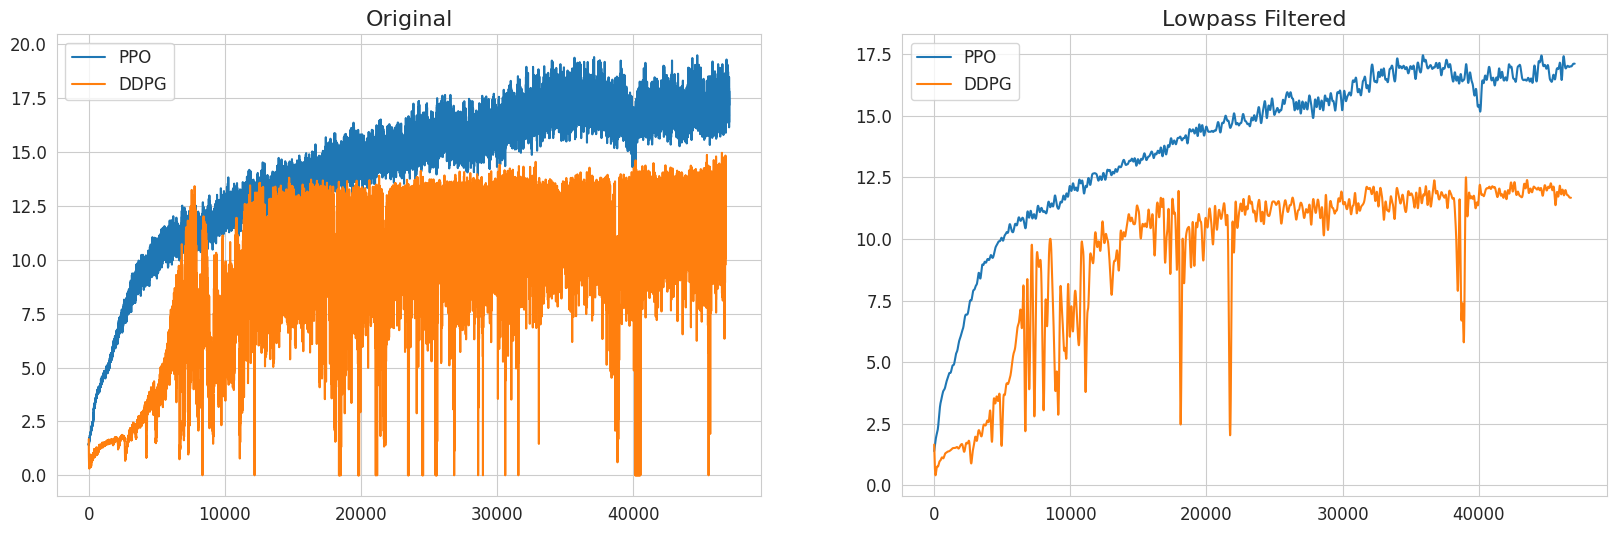

In [87]:
# Plot the first curve before and after lowpass filtering
# curve = ep_rew_clean[ep_rew_clean['seed'] == '37']['value'].values
# lowpass_curve = lowpass_filter(curve, lowpass_thresh=0.01)

ppo_curve = all_df[(all_df['algo'] == 'PPO') & (all_df['seed'] == 303) & (
    all_df['task'] == 'dog_pace')][
  'episode_reward'].values

ddpg_curve = all_df[(all_df['algo'] == 'DDPG') & (all_df['seed'] == 303) & (
    all_df['task'] == 'dog_pace')][
  'episode_reward'].values

low_pass_ppo_curve = lowpass_filter(ppo_curve, lowpass_thresh=0.01)
low_pass_ddpg_curve = lowpass_filter(ddpg_curve, lowpass_thresh=0.01)

# plot both curves with the original on the left, and lowpass on the right
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(ppo_curve)
axes[0].plot(ddpg_curve)
axes[0].set_title('Original')
axes[1].plot(low_pass_ppo_curve)
axes[1].plot(low_pass_ddpg_curve)
axes[1].set_title('Lowpass Filtered')

#add a legend so it's easy to read
axes[0].legend(['PPO', 'DDPG'])
axes[1].legend(['PPO', 'DDPG'])


In [51]:
def apply_lowpass(curve):
  # Apply the lowpass filter directly on the curve
  low_pass_curve = lowpass_filter(curve, lowpass_thresh=0.01)
  return low_pass_curve


In [52]:
# Apply the function to the 'episode_reward' column of each group and assign the result to a new column
all_df['lowpass_episode_reward'] = \
  all_df.groupby(['domain', 'task', 'algo', 'experiment', 'seed'])[
    'episode_reward'].transform(apply_lowpass)
all_df.keys()

Index(['Unnamed: 0', 'step', 'episode_reward', 'timestamp', 'seed',
       'experiment', 'algo', 'domain', 'task', 'timestamp_adjusted',
       'expertise_level', 'lowpass_episode_reward'],
      dtype='object')

In [53]:
def compute_dispersion(curve):
  # Compute the dispersion as the IQR of the curve
  return scipy.stats.iqr(curve)

In [95]:
# Group by 'domain', 'task', 'algo', and 'steps', then apply the IQR computation
dispersion_df = all_df.groupby(['domain', 'algo', 'task', 'step'])[
  'lowpass_episode_reward'].apply(compute_dispersion).reset_index()

# Renaming the column for clarity
dispersion_df.rename(columns={'lowpass_episode_reward': 'iqr_dispersion'},
                     inplace=True)
dispersion_df

,domain,algo,task,step,iqr_dispersion
0,quadruped_locomotion,DDPG,dog_pace,0,0.199439
1,quadruped_locomotion,DDPG,dog_pace,1,0.189804
2,quadruped_locomotion,DDPG,dog_pace,2,0.180195
3,quadruped_locomotion,DDPG,dog_pace,3,0.170616
4,quadruped_locomotion,DDPG,dog_pace,4,0.162672
...,...,...,...,...,...
281524,quadruped_locomotion,PPO,dog_trot,47054,0.402144
281525,quadruped_locomotion,PPO,dog_trot,47055,0.402144
281526,quadruped_locomotion,PPO,dog_trot,47056,0.402144
281527,quadruped_locomotion,PPO,dog_trot,47057,0.402144


In [97]:
# Now that we have the dispersion values for specific steps, we can compute the mean and std of the dispersion for each algo
mean_dispersion = dispersion_df.groupby(['domain', 'algo', 'task'])[
  'iqr_dispersion'].mean()
std_dispersion = dispersion_df.groupby(['domain', 'algo', 'task'])[
  'iqr_dispersion'].std()


In [99]:
# Display the means and stds nicely. Should be durations for domain/algo/task
for domain in mean_dispersion.index.levels[0]:
  print(domain)
  for algo in mean_dispersion.index.levels[1]:
    print(f'\t{algo}')
    for task in mean_dispersion.loc[domain, algo].index:
      print(
          f'\t\tTask: {task}, Mean Dispersion: {mean_dispersion.loc[domain, algo, task]}, Std Dispersion: {std_dispersion.loc[domain, algo, task]}')
      all_training_metrics[(domain, algo, task)][
        'dispersion_across_runs'] = dict(
          mean=mean_dispersion.loc[domain, algo, task],
          std=std_dispersion.loc[domain, algo, task])

quadruped_locomotion
	DDPG
		Task: dog_pace, Mean Dispersion: 4.298872195852825, Std Dispersion: 1.8586737223266083
		Task: dog_spin, Mean Dispersion: 1.2980456788733505, Std Dispersion: 1.3104404071509652
		Task: dog_trot, Mean Dispersion: 2.4508043567584052, Std Dispersion: 1.2043425057864692
	PPO
		Task: dog_pace, Mean Dispersion: 0.4608676592465547, Std Dispersion: 0.17096964470494852
		Task: dog_spin, Mean Dispersion: 1.8457169899833263, Std Dispersion: 1.2501810395547666
		Task: dog_trot, Mean Dispersion: 0.49956323788782736, Std Dispersion: 0.3169994449677254


## System Metrics

In [57]:
training_system_metric_dirs = []
for domain, _ in all_df.groupby('domain'):
  for task, _ in all_df.groupby('task'):
    for algo, _ in all_df.groupby('algo'):
      for exp_id, _ in all_df.groupby('experiment'):
        for seed, _ in all_df.groupby('seed'):
          experiment_path = os.path.join(base_dir, domain,
                                         task, algo.lower(), str(exp_id),
                                         f'**/train_emissions.csv')
          print(f'Experiment Path: {experiment_path}')

          training_system_metric_dirs.extend(glob.glob(experiment_path,
                                                       recursive=True))
len(training_system_metric_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/train_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/q

600

In [58]:
training_system_metric_dirs = set(training_system_metric_dirs)
len(training_system_metric_dirs)

60

In [59]:
training_system_metrics_df = []
for metric_dir in training_system_metric_dirs:
  split_dir = metric_dir.split('/')
  domain = split_dir[6]
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  print(exp_name_split)
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]
  task = split_dir[-6]
  algo = algo.upper()
  print(f'Processing Experiment: {experiment}, Seed: {seed}, Algo: {algo}')

  df = pd.read_csv(metric_dir)
  df['seed'] = int(seed)
  df['experiment'] = int(experiment)
  df['algo'] = algo
  df['task'] = task
  df['domain'] = domain
  df['timestamp'] = pd.to_datetime(df['timestamp']).apply(
      lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
  training_system_metrics_df.append(df)
training_system_metrics_df = pd.concat(training_system_metrics_df)
training_system_metrics_df

['quadruped', 'locomotion', 'algo', 'ddpg', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '345', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 345, Algo: DDPG
['quadruped', 'locomotion', 'algo', 'ddpg', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '293', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 293, Algo: DDPG
['quadruped', 'locomotion', 'algo', 'ppo', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '65', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 65, Algo: PPO
['quadruped', 'locomotion', 'algo', 'ddpg', 'int', 'eval', 'freq', '100000', 'int', 'save', 'freq', '1000000', 'parallel', 'cores', '170', 'seed', '345', 'total', 'env', 'steps', '200000000']
Processing Experiment: 2223, Seed: 345, Algo: DDPG
['quadruped', 'locomotion', 'alg

,timestamp,project_name,run_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,...,latitude,ram_total_size,ram_process,tracking_mode,on_cloud,seed,experiment,algo,task,domain
0,2023-11-21 14:52:19,rlperf_quadruped_locomomtion_train,24bb2d97-1f29-45b6-839d-8e70d3ae6cfc,5.028996,0.000078,0.000015,120.0,0.0,29.495924,0.000168,...,NaN,1417.290230,78.658588,process,N,345,2223,DDPG,dog_trot,quadruped_locomotion
1,2023-11-21 14:52:24,rlperf_quadruped_locomomtion_train,24bb2d97-1f29-45b6-839d-8e70d3ae6cfc,10.015198,0.000180,0.000018,120.0,0.0,78.734748,0.000334,...,NaN,1417.290230,209.973915,process,N,345,2223,DDPG,dog_trot,quadruped_locomotion
2,2023-11-21 14:52:29,rlperf_quadruped_locomomtion_train,24bb2d97-1f29-45b6-839d-8e70d3ae6cfc,15.014319,0.000284,0.000019,120.0,0.0,81.455546,0.000500,...,NaN,1417.290230,217.214790,process,N,345,2223,DDPG,dog_trot,quadruped_locomotion
3,2023-11-21 14:52:34,rlperf_quadruped_locomomtion_train,24bb2d97-1f29-45b6-839d-8e70d3ae6cfc,20.014534,0.000388,0.000019,120.0,0.0,81.458304,0.000667,...,NaN,1417.290230,217.222145,process,N,345,2223,DDPG,dog_trot,quadruped_locomotion
4,2023-11-21 14:52:39,rlperf_quadruped_locomomtion_train,24bb2d97-1f29-45b6-839d-8e70d3ae6cfc,25.025477,0.000493,0.000020,120.0,0.0,81.581115,0.000834,...,NaN,1417.290230,217.549706,process,N,345,2223,DDPG,dog_trot,quadruped_locomotion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,2023-11-22 00:49:52,rlperf_quadruped_locomomtion_train,85174f3f-e5e8-4f10-8753-25723c9437d9,30944.182194,0.577371,0.000019,120.0,0.0,60.880979,1.031451,...,NaN,1417.290184,162.349277,process,N,303,2223,PPO,dog_spin,quadruped_locomotion
6188,2023-11-22 00:49:57,rlperf_quadruped_locomomtion_train,85174f3f-e5e8-4f10-8753-25723c9437d9,30949.183277,0.577465,0.000019,120.0,0.0,60.881088,1.031617,...,NaN,1417.290184,162.349567,process,N,303,2223,PPO,dog_spin,quadruped_locomotion
6189,2023-11-22 00:50:02,rlperf_quadruped_locomomtion_train,85174f3f-e5e8-4f10-8753-25723c9437d9,30954.176776,0.577558,0.000019,120.0,0.0,60.883547,1.031784,...,NaN,1417.290184,162.356125,process,N,303,2223,PPO,dog_spin,quadruped_locomotion
6190,2023-11-22 00:50:07,rlperf_quadruped_locomomtion_train,85174f3f-e5e8-4f10-8753-25723c9437d9,30959.172059,0.577651,0.000019,120.0,0.0,60.883548,1.031950,...,NaN,1417.290184,162.356129,process,N,303,2223,PPO,dog_spin,quadruped_locomotion


In [100]:
# Get the last duration for each individual experiment
last_durations = \
  training_system_metrics_df.groupby(
      ['domain', 'algo', 'task', 'experiment', 'seed'])[
    'duration'].last()

In [101]:
# Now find the mean and std of the last duration for each algo
mean_last_duration = last_durations.groupby(['domain', 'algo', 'task']).mean()
std_last_duration = last_durations.groupby(['domain', 'algo', 'task']).std()
mean_last_duration

domain                algo  task    
quadruped_locomotion  DDPG  dog_pace    58246.953250
                            dog_spin    54602.998271
                            dog_trot    58899.068496
                      PPO   dog_pace    30213.623636
                            dog_spin    31412.825243
                            dog_trot    29714.107426
Name: duration, dtype: float64

In [102]:
mean_last_duration.index.levels

FrozenList([['quadruped_locomotion'], ['DDPG', 'PPO'], ['dog_pace', 'dog_spin', 'dog_trot']])

In [103]:
# Display the means and stds nicely. Should be durations for domain/algo/task
for domain in mean_last_duration.index.levels[0]:
  print(domain)
  for algo in mean_last_duration.index.levels[1]:
    print(f'\t{algo}')
    for task in mean_last_duration.loc[domain, algo].index:
      print(
          f'\t\tTask: {task}, Mean Last Duration: {mean_last_duration.loc[domain, algo, task]}, Std Last Duration: {std_last_duration.loc[domain, algo, task]}')
      all_training_metrics[(domain, algo, task)]['wall_clock_time'] = dict(
          mean=mean_last_duration.loc[domain, algo, task],
          std=std_last_duration.loc[domain, algo, task])

quadruped_locomotion
	DDPG
		Task: dog_pace, Mean Last Duration: 58246.95324952602, Std Last Duration: 1665.510758586944
		Task: dog_spin, Mean Last Duration: 54602.99827070236, Std Last Duration: 1918.185486933768
		Task: dog_trot, Mean Last Duration: 58899.068496346474, Std Last Duration: 2316.680569899027
	PPO
		Task: dog_pace, Mean Last Duration: 30213.623635864256, Std Last Duration: 889.0072983030313
		Task: dog_spin, Mean Last Duration: 31412.825242590905, Std Last Duration: 889.0478394044369
		Task: dog_trot, Mean Last Duration: 29714.107426166534, Std Last Duration: 919.2155188821256


In [104]:
training_peak_ram_usage = \
  training_system_metrics_df.groupby(
      ['domain', 'algo', 'task', 'experiment', 'seed'])[
    'ram_process'].max()

training_mean_peak_ram = training_peak_ram_usage.groupby(
    ['domain', 'algo', 'task']).mean()
training_std_peak_ram = training_peak_ram_usage.groupby(
    ['domain', 'algo', 'task']).std()

# Display the means and stds nicely
for domain in training_mean_peak_ram.index.levels[0]:
  for algo in training_mean_peak_ram.index.levels[1]:
    for task in training_mean_peak_ram.index.levels[2]:
      all_training_metrics[(domain, algo, task)]['peak_ram_usage'] = dict(
          mean=training_mean_peak_ram.loc[domain, algo, task],
          std=training_std_peak_ram.loc[domain, algo, task])

      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean Peak RAM Usage: {training_mean_peak_ram.loc[domain, algo, task]}, Std Peak RAM Usage: {training_std_peak_ram.loc[domain, algo, task]}')

Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean Peak RAM Usage: 505.6251274108887, Std Peak RAM Usage: 0.2768329046586508
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean Peak RAM Usage: 509.1189254760742, Std Peak RAM Usage: 1.2445501854437646
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean Peak RAM Usage: 507.2639873504639, Std Peak RAM Usage: 0.9335728211556273
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean Peak RAM Usage: 162.36882667541505, Std Peak RAM Usage: 0.027127552831131687
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean Peak RAM Usage: 162.37122688293456, Std Peak RAM Usage: 0.04957140014102335
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean Peak RAM Usage: 162.38510551452637, Std Peak RAM Usage: 0.05385796886147304


In [105]:
mean_training_ram_usage = \
  training_system_metrics_df.groupby(['domain', 'algo', 'task'])[
    'ram_process'].mean()
std_training_ram_usage = \
  training_system_metrics_df.groupby(['domain', 'algo', 'task'])[
    'ram_process'].std()

# Display the means and stds nicely
for domain in mean_training_ram_usage.index.levels[0]:
  for algo in mean_training_ram_usage.index.levels[1]:
    for task in mean_training_ram_usage.index.levels[2]:
      all_training_metrics[(domain, algo, task)]['ram_usage'] = dict(
          mean=mean_training_ram_usage.loc[domain, algo, task],
          std=std_training_ram_usage.loc[domain, algo, task])

      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean RAM Usage: {mean_training_ram_usage.loc[domain, algo, task]}, Std RAM Usage: {std_training_ram_usage.loc[domain, algo, task]}')

Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean RAM Usage: 387.24436554686804, Std RAM Usage: 90.32754887393146
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean RAM Usage: 388.76000056927023, Std RAM Usage: 92.74773541762816
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean RAM Usage: 389.0531136634145, Std RAM Usage: 90.75233316822164
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean RAM Usage: 162.29312047417963, Std RAM Usage: 2.5367956844882427
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean RAM Usage: 162.29761989974776, Std RAM Usage: 2.4889910356391916
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean RAM Usage: 162.30331740320838, Std RAM Usage: 2.6912764407482284


## Computing the Training Sample Cost


In [66]:
# system_metrics_df['timestamp'] = pd.to_datetime(system_metrics_df['timestamp'])
# pd.merge_asof(top_k_policies_df, system_metrics_df, left_on='timestamp',
#               right_on='timestamp', direction='nearest', )

---
# Inference Metrics


In [67]:
all_inference_metrics = collections.defaultdict(dict)

## Reliability Metrics

In [68]:
log_dirs = []

for domain, domain_group in all_df.groupby('domain'):
  for algo, algo_group in domain_group.groupby('algo'):
    for exp_id, exp_group in algo_group.groupby('experiment'):
      for task, task_group in exp_group.groupby('task'):
        for seed, seed_group in task_group.groupby('seed'):
          experiment_path = os.path.join(base_dir, domain, task, algo.lower(),
                                         str(exp_id),
                                         f'**/inference_metrics_results.json')
          print(f'Experiment Path: {experiment_path}')

          log_dirs.extend(glob.glob(experiment_path, recursive=True))
len(log_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_metrics_results.json
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**

580

In [69]:
log_dirs = set(log_dirs)
len(log_dirs)

58

In [70]:
inference_df = []

for log_dir in log_dirs:
  split_dir = os.path.normpath(log_dir).split(os.sep)
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]
  task = split_dir[-6]
  domain = split_dir[-7]

  print(
      f'Processing Experiment: {experiment}, Seed: {seed}, Domain: {domain}, Task: {task}, Algo: {algo}')

  data = json.load(open(log_dir))

  for metric, values in data.items():
    df = pd.DataFrame.from_dict(values['values'], orient='columns', )
    df['domain'] = domain
    df['task'] = task
    df['seed'] = int(seed)
    df['experiment'] = int(experiment)
    df['algo'] = algo
    df['algo'] = df['algo'].str.upper()
    df['metric'] = metric
    inference_df.append(df)
inference_df = pd.concat(inference_df)
inference_df

Processing Experiment: 2223, Seed: 182, Domain: quadruped_locomotion, Task: dog_spin, Algo: ddpg
Processing Experiment: 2223, Seed: 345, Domain: quadruped_locomotion, Task: dog_pace, Algo: ppo
Processing Experiment: 2223, Seed: 303, Domain: quadruped_locomotion, Task: dog_spin, Algo: ppo
Processing Experiment: 2223, Seed: 182, Domain: quadruped_locomotion, Task: dog_trot, Algo: ppo
Processing Experiment: 2223, Seed: 215, Domain: quadruped_locomotion, Task: dog_pace, Algo: ddpg
Processing Experiment: 2223, Seed: 303, Domain: quadruped_locomotion, Task: dog_pace, Algo: ppo
Processing Experiment: 2223, Seed: 318, Domain: quadruped_locomotion, Task: dog_pace, Algo: ppo
Processing Experiment: 2223, Seed: 303, Domain: quadruped_locomotion, Task: dog_trot, Algo: ddpg
Processing Experiment: 2223, Seed: 303, Domain: quadruped_locomotion, Task: dog_trot, Algo: ppo
Processing Experiment: 2223, Seed: 345, Domain: quadruped_locomotion, Task: dog_trot, Algo: ppo
Processing Experiment: 2223, Seed: 33

,0,domain,task,seed,experiment,algo,metric
0,0.012546,quadruped_locomotion,dog_spin,182,2223,DDPG,inference_time
1,0.000300,quadruped_locomotion,dog_spin,182,2223,DDPG,inference_time
2,0.000223,quadruped_locomotion,dog_spin,182,2223,DDPG,inference_time
3,0.000217,quadruped_locomotion,dog_spin,182,2223,DDPG,inference_time
4,0.000203,quadruped_locomotion,dog_spin,182,2223,DDPG,inference_time
...,...,...,...,...,...,...,...
95,19.114783,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
96,15.890728,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
97,13.786211,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
98,10.748945,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns


### Risk Across Rollouts and Dispersion Across Rollouts

In [71]:
# Get the bottom "alpha" percent of rollouts (we use the 5th percentile to get the bottom 5% of rollouts)
reliability_df = inference_df[inference_df['metric'] == 'rollout_returns']
for domain, domain_group in reliability_df.groupby('domain'):
  print(f'Processing domain: {domain}')
  for task, task_group in domain_group.groupby('task'):
    print(f'\tProcessing task: {task}')
    for algo, algo_group in task_group.groupby('algo'):
      print(f'\t\tProcessing algo: {algo}')
      values = algo_group[0]

      # get the bottom 5% of rollouts
      bottom_alpha_percent = np.percentile(values, 5)

      # CVaR is the average of the bottom "alpha" percent of rollouts
      cvar = np.mean(values[values <= bottom_alpha_percent])
      print(f'\t\t\tCVaR: {cvar}')

      all_inference_metrics[(domain, algo, task,)][
        'risk_across_rollouts'] = cvar

      # Also get the dispersion across rollouts
      iqr = scipy.stats.iqr(values)
      print(f'\t\t\tIQR: {iqr}')
      all_inference_metrics[(domain, algo, task,)][
        'dispersion_across_rollouts'] = iqr

Processing domain: quadruped_locomotion
	Processing task: dog_pace
		Processing algo: DDPG
			CVaR: 1.766578857860566
			IQR: 15.402972642129985
		Processing algo: PPO
			CVaR: 9.543727250608363
			IQR: 6.599943071556318
	Processing task: dog_spin
		Processing algo: DDPG
			CVaR: 0.11835333039275711
			IQR: 2.5689193357507727
		Processing algo: PPO
			CVaR: 4.5938853858296245
			IQR: 41.75882665631869
	Processing task: dog_trot
		Processing algo: DDPG
			CVaR: 1.3646869840075668
			IQR: 7.12550184932031
		Processing algo: PPO
			CVaR: 3.994579963085168
			IQR: 5.8421140784952925


In [72]:
reliability_df

,0,domain,task,seed,experiment,algo,metric
0,6.997258,quadruped_locomotion,dog_spin,182,2223,DDPG,rollout_returns
1,4.000354,quadruped_locomotion,dog_spin,182,2223,DDPG,rollout_returns
2,7.280794,quadruped_locomotion,dog_spin,182,2223,DDPG,rollout_returns
3,3.265678,quadruped_locomotion,dog_spin,182,2223,DDPG,rollout_returns
4,3.203349,quadruped_locomotion,dog_spin,182,2223,DDPG,rollout_returns
...,...,...,...,...,...,...,...
95,19.114783,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
96,15.890728,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
97,13.786211,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns
98,10.748945,quadruped_locomotion,dog_trot,336,2223,PPO,rollout_returns


In [73]:
# Performance is actually a training metric, but we can compute it here using the rollout returns of final policies in realibility_df
mean_performance = reliability_df.groupby(['domain', 'algo', 'task'])[0].mean()
std_performance = reliability_df.groupby(['domain', 'algo', 'task'])[0].std()

In [74]:
# Display the means and stds nicely
for domain in mean_performance.index.levels[0]:
  for algo in mean_performance.index.levels[1]:
    for task in mean_performance.index.levels[2]:
      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean Performance: {mean_performance.loc[domain, algo, task]}, Std Performance: {std_performance.loc[domain, algo, task]}')
      all_training_metrics[(domain, algo, task)]['returns'] = dict(
          mean=mean_performance.loc[domain, algo, task],
          std=std_performance.loc[domain, algo, task])

Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean Performance: 12.65280991894213, Std Performance: 7.78697255146514
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean Performance: 4.148786946727998, Std Performance: 2.4686718027581382
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean Performance: 6.110852507208027, Std Performance: 4.466469111968719
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean Performance: 18.098877568266136, Std Performance: 6.010194990422281
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean Performance: 48.947308531364, Std Performance: 37.24210898712075
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean Performance: 12.97084679063737, Std Performance: 5.161761117526269


In [75]:
# Mean/STD of the inference time metric
inference_time_df = inference_df[inference_df['metric'] == 'inference_time']
mean_inference_time = inference_time_df.groupby(['domain', 'algo', 'task', ])[
  0].mean()
std_inference_time = inference_time_df.groupby(['domain', 'algo', 'task', ])[
  0].std()
mean_inference_time, std_inference_time

(domain                algo  task    
 quadruped_locomotion  DDPG  dog_pace    0.000184
                             dog_spin    0.000185
                             dog_trot    0.000181
                       PPO   dog_pace    0.000239
                             dog_spin    0.000216
                             dog_trot    0.000216
 Name: 0, dtype: float64,
 domain                algo  task    
 quadruped_locomotion  DDPG  dog_pace    0.000382
                             dog_spin    0.000391
                             dog_trot    0.000382
                       PPO   dog_pace    0.000811
                             dog_spin    0.000263
                             dog_trot    0.000265
 Name: 0, dtype: float64)

In [76]:
# Add results to the dict
for domain, domain_group in mean_inference_time.groupby('domain'):
  for algo, algo_group in domain_group.groupby('algo'):
    for task, task_group in algo_group.groupby('task'):
      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean Inference Time: {mean_inference_time.loc[domain, algo, task]}, Std Inference Time: {std_inference_time.loc[domain, algo, task]}')
      all_inference_metrics[(domain, algo, task,)]['inference_time'] = dict(
          mean=mean_inference_time.loc[domain, algo, task],
          std=std_inference_time.loc[domain, algo, task])


Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean Inference Time: 0.00018368245435412974, Std Inference Time: 0.0003818657207370547
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean Inference Time: 0.00018489990098169074, Std Inference Time: 0.0003905789198229648
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean Inference Time: 0.0001814395362394862, Std Inference Time: 0.00038246073143839395
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean Inference Time: 0.00023889993000775575, Std Inference Time: 0.0008108503028773419
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean Inference Time: 0.00021640170351602136, Std Inference Time: 0.00026288541996197224
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean Inference Time: 0.0002157955166620377, Std Inference Time: 0.00026527469738003276


## System Metrics


In [77]:
log_dirs = []

for domain, domain_group in all_df.groupby('domain'):
  for algo, algo_group in domain_group.groupby('algo'):
    for exp_id, exp_group in algo_group.groupby('experiment'):
      for task, task_group in exp_group.groupby('task'):
        for seed, seed_group in task_group.groupby('seed'):
          experiment_path = os.path.join(base_dir, domain, task, algo.lower(),
                                         str(exp_id),
                                         f'**/inference_emissions.csv')
          print(f'Experiment Path: {experiment_path}')

          log_dirs.extend(glob.glob(experiment_path, recursive=True))
len(log_dirs)

Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/ikechukwuu/workspace/gcs/a2perf/quadruped_locomotion/dog_pace/ddpg/2223/**/inference_emissions.csv
Experiment Path: /home/i

580

In [78]:
log_dirs = set(log_dirs)
len(log_dirs)

58

In [79]:
inference_system_metrics_df = []
for log_dir in log_dirs:
  split_dir = os.path.normpath(log_dir).split(os.sep)
  exp_name = split_dir[-3]
  exp_name_split = exp_name.split('_')
  seed = exp_name_split[-5]
  experiment = split_dir[-4]
  algo = split_dir[-5]
  task = split_dir[-6]
  domain = split_dir[-7]

  print(
      f'Processing Experiment: {experiment}, Seed: {seed}, Domain: {domain}, Algo: {algo}, Task: {task}')

  df = pd.read_csv(log_dir)
  df['domain'] = domain
  df['task'] = task
  df['seed'] = seed
  df['experiment'] = experiment
  df['algo'] = algo
  df['algo'] = df['algo'].str.upper()
  inference_system_metrics_df.append(df)
inference_system_metrics_df = pd.concat(inference_system_metrics_df)
inference_system_metrics_df

Processing Experiment: 2223, Seed: 182, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_spin
Processing Experiment: 2223, Seed: 182, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_trot
Processing Experiment: 2223, Seed: 318, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_trot
Processing Experiment: 2223, Seed: 303, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_spin
Processing Experiment: 2223, Seed: 215, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_pace
Processing Experiment: 2223, Seed: 182, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_pace
Processing Experiment: 2223, Seed: 98, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_trot
Processing Experiment: 2223, Seed: 318, Domain: quadruped_locomotion, Algo: ppo, Task: dog_trot
Processing Experiment: 2223, Seed: 491, Domain: quadruped_locomotion, Algo: ddpg, Task: dog_spin
Processing Experiment: 2223, Seed: 215, Domain: quadruped_locomotion, Algo: ppo, Task: dog_spin
Processing Experiment: 2223, Seed

,timestamp,project_name,run_id,duration,emissions,emissions_rate,cpu_power,gpu_power,ram_power,cpu_energy,...,latitude,ram_total_size,ram_process,tracking_mode,on_cloud,domain,task,seed,experiment,algo
0,2023-11-28T18:34:51,rlperf_quadruped_locomotion_inference_debug,f2b46f4e-b105-4047-b5fe-faa61b0673bc,1.026560,0.000005,0.000004,42.5,0.0,0.360731,0.000012,...,NaN,1417.290165,0.961952,process,N,quadruped_locomotion,dog_spin,182,2223,DDPG
1,2023-11-28T18:34:52,rlperf_quadruped_locomotion_inference_debug,f2b46f4e-b105-4047-b5fe-faa61b0673bc,2.032603,0.000009,0.000004,42.5,0.0,0.360837,0.000024,...,NaN,1417.290165,0.962231,process,N,quadruped_locomotion,dog_spin,182,2223,DDPG
2,2023-11-28T18:34:53,rlperf_quadruped_locomotion_inference_debug,f2b46f4e-b105-4047-b5fe-faa61b0673bc,3.032539,0.000013,0.000004,42.5,0.0,0.360842,0.000036,...,NaN,1417.290165,0.962254,process,N,quadruped_locomotion,dog_spin,182,2223,DDPG
3,2023-11-28T18:34:54,rlperf_quadruped_locomotion_inference_debug,f2b46f4e-b105-4047-b5fe-faa61b0673bc,4.029329,0.000018,0.000004,42.5,0.0,0.360854,0.000048,...,NaN,1417.290165,0.962280,process,N,quadruped_locomotion,dog_spin,182,2223,DDPG
4,2023-11-28T18:34:55,rlperf_quadruped_locomotion_inference_debug,f2b46f4e-b105-4047-b5fe-faa61b0673bc,5.030029,0.000022,0.000004,42.5,0.0,0.360855,0.000059,...,NaN,1417.290165,0.962280,process,N,quadruped_locomotion,dog_spin,182,2223,DDPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2023-11-27T18:55:46,rlperf_quadruped_locomotion_inference_debug,ef327415-36c1-4ac8-b325-be5774194642,213.372063,0.000946,0.000004,42.5,0.0,0.363230,0.002518,...,NaN,1417.290176,0.968613,process,N,quadruped_locomotion,dog_pace,345,2223,DDPG
590,2023-11-27T18:55:47,rlperf_quadruped_locomotion_inference_debug,ef327415-36c1-4ac8-b325-be5774194642,214.373669,0.000950,0.000004,42.5,0.0,0.363230,0.002529,...,NaN,1417.290176,0.968613,process,N,quadruped_locomotion,dog_pace,345,2223,DDPG
591,2023-11-27T18:55:48,rlperf_quadruped_locomotion_inference_debug,ef327415-36c1-4ac8-b325-be5774194642,215.384228,0.000955,0.000004,42.5,0.0,0.363230,0.002541,...,NaN,1417.290176,0.968613,process,N,quadruped_locomotion,dog_pace,345,2223,DDPG
592,2023-11-27T18:55:49,rlperf_quadruped_locomotion_inference_debug,ef327415-36c1-4ac8-b325-be5774194642,216.382602,0.000959,0.000004,42.5,0.0,0.363230,0.002553,...,NaN,1417.290176,0.968613,process,N,quadruped_locomotion,dog_pace,345,2223,DDPG


In [80]:
inference_peak_ram = \
  inference_system_metrics_df.groupby(
      ['domain', 'algo', 'task', 'experiment', 'seed'])[
    'ram_process'].max()

inference_mean_peak_ram = inference_peak_ram.groupby(
    ['domain', 'algo', 'task']).mean()
inference_std_peak_ram = inference_peak_ram.groupby(
    ['domain', 'algo', 'task']).std()

In [81]:
# Display the means and stds nicely
for domain in inference_mean_peak_ram.index.levels[0]:
  for algo in inference_mean_peak_ram.index.levels[1]:
    for task in inference_mean_peak_ram.index.levels[2]:
      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean Peak RAM: {inference_mean_peak_ram.loc[domain, algo, task]}, Std Peak RAM: {inference_std_peak_ram.loc[domain, algo, task]}')
      all_inference_metrics[(domain, algo, task)]['peak_ram_usage'] = dict(
          mean=inference_mean_peak_ram.loc[domain, algo, task],
          std=inference_std_peak_ram.loc[domain, algo, task])

Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean Peak RAM: 0.9745494842529296, Std Peak RAM: 0.0024357551830560325
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean Peak RAM: 0.9641180038452148, Std Peak RAM: 0.0026360033262464275
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean Peak RAM: 0.9660739898681641, Std Peak RAM: 0.0028823275482072032
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean Peak RAM: 0.9960544586181641, Std Peak RAM: 0.00043011282601977045
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean Peak RAM: 0.9967487335205079, Std Peak RAM: 0.0004804501455063756
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean Peak RAM: 1.0036212921142578, Std Peak RAM: 0.004963665048900403


In [82]:
inference_mean_ram_usage = \
  inference_system_metrics_df.groupby(['domain', 'algo', 'task'])[
    'ram_process'].mean()
inference_std_ram_usage = \
  inference_system_metrics_df.groupby(['domain', 'algo', 'task'])[
    'ram_process'].std()
inference_mean_ram_usage, inference_std_ram_usage

(domain                algo  task    
 quadruped_locomotion  DDPG  dog_pace    0.971084
                             dog_spin    0.963724
                             dog_trot    0.965001
                       PPO   dog_pace    0.992835
                             dog_spin    0.992633
                             dog_trot    0.999835
 Name: ram_process, dtype: float64,
 domain                algo  task    
 quadruped_locomotion  DDPG  dog_pace    0.004601
                             dog_spin    0.002200
                             dog_trot    0.003444
                       PPO   dog_pace    0.003394
                             dog_spin    0.003416
                             dog_trot    0.006466
 Name: ram_process, dtype: float64)

In [83]:
for domain in inference_mean_ram_usage.index.levels[0]:
  for algo in inference_mean_ram_usage.index.levels[1]:
    for task in inference_mean_ram_usage.index.levels[2]:
      print(
          f'Domain: {domain}, Algo: {algo}, Task: {task}, Mean RAM Usage: {inference_mean_ram_usage.loc[domain, algo, task]}, Std RAM Usage: {inference_std_ram_usage.loc[domain, algo, task]}')
      all_inference_metrics[(domain, algo, task)]['ram_usage'] = dict(
          mean=inference_mean_ram_usage.loc[domain, algo, task],
          std=inference_std_ram_usage.loc[domain, algo, task])

Domain: quadruped_locomotion, Algo: DDPG, Task: dog_pace, Mean RAM Usage: 0.9710838723033026, Std RAM Usage: 0.004600525113803316
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_spin, Mean RAM Usage: 0.9637244827637788, Std RAM Usage: 0.002200126879888901
Domain: quadruped_locomotion, Algo: DDPG, Task: dog_trot, Mean RAM Usage: 0.9650012915014806, Std RAM Usage: 0.0034441525440687803
Domain: quadruped_locomotion, Algo: PPO, Task: dog_pace, Mean RAM Usage: 0.9928346298238591, Std RAM Usage: 0.0033942666826833985
Domain: quadruped_locomotion, Algo: PPO, Task: dog_spin, Mean RAM Usage: 0.9926333096598609, Std RAM Usage: 0.0034164242797914187
Domain: quadruped_locomotion, Algo: PPO, Task: dog_trot, Mean RAM Usage: 0.9998354489550992, Std RAM Usage: 0.0064656850728728905


# Display all metrics nicely

In [110]:
train_table = dict(
    category={
        "Application": ["returns"],
        "Reliability": ["dispersion_across_runs", "dispersion_within_runs",
                        "short_term_risk",
                        "long_term_risk", "risk_across_runs"],
        "System": ["peak_ram_usage", "ram_usage", "wall_clock_time"]
    }
    ,
    units={
        "Application": ['100 eps.'],
        "Reliability": ["IQR", "IQR", "CVaR", "CVaR", "CVaR"],
        "System": ["GB", "GB", "Hours"]
    })

inference_table = dict(
    category={
        "Application": ['N/A'],
        "Reliability": ["dispersion_across_rollouts", "risk_across_rollouts"],
        "System": ["peak_ram_usage", "ram_usage", "inference_time"]
    },
    units={
        "Application": [''],
        "Reliability": ["IQR", "CVaR"],
        "System": ["GB", "GB", "ms"]
    }
)

criteria_dict = dict(
    returns='max',
    dispersion_across_runs='min',
    dispersion_within_runs='min',
    dispersion_across_rollouts='min',
    short_term_risk='min',
    long_term_risk='min',
    risk_across_runs='max',
    peak_ram_usage='min',
    ram_usage='min',
    wall_clock_time='min',
    inference_time='min'
)

In [111]:
def format_number(num):
  if -1000 < num < 1000:
    return f"{num:.2f}"
  else:
    return f"{num:.2e}"


def format_number_bold(num, is_bold):
  formatted_num = format_number(num)
  return f"\\textbf{{{formatted_num}}}" if is_bold else formatted_num


def is_best(value, all_values, criteria):
  if criteria == 'max':
    return value == max(all_values)
  elif criteria == 'min':
    return value == min(all_values)
  return False


def generate_latex_table_header(task_name, phase):
  header_title = task_name.replace('_', ' ').title()
  header = [
      f'\\multicolumn{{4}}{{|c|}}{{\\textbf{{{header_title} ({phase})}}}} \\\\',
      '\\hline',
      '\\textbf{Category} & \\textbf{Metric Name} & \\textbf{PPO} & \\textbf{DDPG} \\\\',
      '\\hline'
  ]
  return '\n'.join(header)


def get_metric_values(metrics_dict, domain, task, metric, criteria):
  metric_values = {}
  all_values = []

  # Collect all mean values for comparison
  for algo in ["PPO", "DDPG"]:
    key = (domain, algo, task)
    if key in metrics_dict and metric in metrics_dict[key]:
      values = metrics_dict[key][metric]
      mean_val = values['mean'] if isinstance(values, dict) else values
      all_values.append(mean_val)

  # Determine the best value and format numbers
  for algo in ["PPO", "DDPG"]:
    key = (domain, algo, task)
    if key in metrics_dict and metric in metrics_dict[key]:
      values = metrics_dict[key][metric]
      mean_val = values['mean'] if isinstance(values, dict) else values
      std_val = values['std'] if isinstance(values,
                                            dict) and 'std' in values else None

      is_bold = is_best(mean_val, all_values, criteria)

      # Special handling for specific metrics
      if metric == 'wall_clock_time':
        mean_val /= 3600
        std_val /= 3600
      elif metric == 'inference_time':
        mean_val *= 1000
        std_val *= 1000

      mean_str = format_number_bold(mean_val, is_bold)
      if std_val:
        std_str = format_number_bold(std_val,
                                     is_bold)  # Bold std if mean is bold
        metric_values[algo] = f"{mean_str} $\\pm$ {std_str}"
      else:
        metric_values[algo] = f"{mean_str}"

    else:
      metric_values[algo] = "N/A"

  return metric_values


def add_metric_rows_to_table(metrics_table, metrics_dict, domain, task,
    criteria_dict):
  latex_table_rows = []
  for category, metrics in metrics_table['category'].items():
    units = metrics_table['units']
    unit_list = units[category]
    first_metric = True
    for i, metric in enumerate(metrics):
      criteria = criteria_dict.get(metric,
                                   'max')  # Default to 'max' if not specified
      metric_values = get_metric_values(metrics_dict, domain, task, metric,
                                        criteria)
      metric_name = f'{metric.replace("_", " ").title()} ({unit_list[i]})'
      row = f'\t\t & {metric_name} & {metric_values["PPO"]} & {metric_values["DDPG"]} \\\\\n'
      if first_metric:
        row = f'\t\t\\multirow{{{len(metrics)}}}{{*}}{{{category}}}' + row
        first_metric = False
      latex_table_rows.append(row)
    latex_table_rows.append('\t\t\\hline\n')
  return ''.join(latex_table_rows)


In [112]:
for domain, domain_group in all_df.groupby('domain'):
  for task, task_group in domain_group.groupby('task'):
    header_title = task.replace('_', ' ').title()
    latex_table_string = ['\\begin{figure}[!htbp]',
                          '\\resizebox{1\\textwidth}{!}{',
                          '\\begin{tabular}{|c|l|c|c|}',
                          '\\hline', ]
    latex_table_string.append(generate_latex_table_header(task, "Training"))

    # Add training metric rows with criteria
    latex_table_string.append(
        add_metric_rows_to_table(train_table, all_training_metrics, domain,
                                 task, criteria_dict))

    # Add inference header
    latex_table_string.append(generate_latex_table_header(task, "Inference"))

    # Add inference metric rows with criteria
    latex_table_string.append(
        add_metric_rows_to_table(inference_table, all_inference_metrics, domain,
                                 task, criteria_dict))

    # Closing tags
    latex_table_string.extend(
        ['\t\\end{tabular}}\n',
         f'\t\\caption{{Training and Inference Metrics for {header_title}}}\n',
         f'\t\\label{{tab:appendix_metrics_{task}}}\n', '\\end{figure}\n'])

    latex_table = ''.join(latex_table_string)
    print(latex_table)
    print("\n\n")

\begin{figure}[!htbp]\resizebox{1\textwidth}{!}{\begin{tabular}{|c|l|c|c|}\hline\multicolumn{4}{|c|}{\textbf{Dog Pace (Training)}} \\
\hline
\textbf{Category} & \textbf{Metric Name} & \textbf{PPO} & \textbf{DDPG} \\
\hline		\multirow{1}{*}{Application}		 & Returns (100 eps.) & \textbf{18.10} $\pm$ \textbf{6.01} & 12.65 $\pm$ 7.79 \\
		\hline
		\multirow{5}{*}{Reliability}		 & Dispersion Across Runs (IQR) & \textbf{0.46} $\pm$ \textbf{0.17} & 4.30 $\pm$ 1.86 \\
		 & Dispersion Within Runs (IQR) & \textbf{0.64} $\pm$ \textbf{0.44} & 3.74 $\pm$ 3.39 \\
		 & Short Term Risk (CVaR) & \textbf{1.28} & 9.24 \\
		 & Long Term Risk (CVaR) & \textbf{3.18} & 22.81 \\
		 & Risk Across Runs (CVaR) & \textbf{16.02} & 13.11 \\
		\hline
		\multirow{3}{*}{System}		 & Peak Ram Usage (GB) & \textbf{162.37} $\pm$ \textbf{0.03} & 505.63 $\pm$ 0.28 \\
		 & Ram Usage (GB) & \textbf{162.29} $\pm$ \textbf{2.54} & 387.24 $\pm$ 90.33 \\
		 & Wall Clock Time (Hours) & \textbf{8.39} $\pm$ \textbf{0.25} & 16.18 $\pm

# Sandbox

In [ ]:

all_metrics_df['rollout_returns']['values'].describe()